# Decodificando um arquivo JPEG passo a passo

JPEG (Joint Photographic Experts Group) é um padrão de compactação de imagens criado em 1992 muito utilizado na internet, é um formato lossy, ou seja, com diminuição na qualidade da imagem. É comum imagens salvas nesse formato [apresentarem artefatos](https://en.wikipedia.org/wiki/Compression_artifact). Outro formato muito utilizado é o PNG (Portable Network Graphics), que é um formato Lossless, ou seja, sem redução na qualidade, geralmente ocupando muito mais espaço que um JPEG, além de permitir o uso de transparencias na imagem, o que em páginas web pode ser importante.

O JPEG utiliza algumas técnicas para compactar a imagem, como a Transformada discreta de cosseno (DCT, Discrete Cosine Transform) e codificação de Huffman, que iremos explicar ao longo deste notebook.

Antes de mais nada gostaria de recomendar alguns materiais extremamente interessantes e úteis:

+ O primeiro é o site [ImpulseAdventure](https://www.impulseadventure.com/photo/) que conta com uma série de artigos explicando o funcionamento do JPEG, como decodificar as tabelas de Huffman, etc.

+ A segunda referência é o projeto [micro-jpeg-visualizer](https://github.com/aguaviva/micro-jpeg-visualizer) de Raul Aguaviva, que é um decoder JPEG escrito em 250 linhas de código Python. Se você quer um código mais robusto recomendo esse projeto, reaproveitei muito do que ele fez. Na realidade até diminuindo a qualidade do código, que era orientado a objetos, deixei em funções, transformei algumas lista puras Python em numpy arrays, que permite operações vetoriais. A licença é a MIT, que mantenho nesse notebook;

+ Este [repositório do Github](https://github.com/corkami/formats/blob/master/image/jpeg.md) contém algumas imagens que explicam o formato de arquivo do JPEG, que são uma mão na roda no momento de fazer o parsing do arquivo;

+ A [Parametric Press](https://parametric.press/issue-01/unraveling-the-jpeg/) tem um interessante artigo, mais alto nível, explicando um pouco o funcionamento do JPEG;

+ Um [guia Romeno](http://www.opennet.ru/docs/formats/jpeg.txt) sobre como o formato funciona, achei esse quando estava terminando de montar esse notebook, muito completo.


## Leitura da imagem usando biblioteca pronta

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from textwrap import wrap

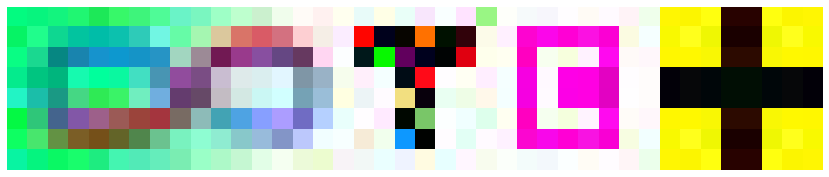

In [2]:
imagem_path = 'teste low quality.jpg'
img = plt.imread(imagem_path)
fig, ax = plt.subplots(figsize=(15, 3))
ax.axis('off')
ax.imshow(img);

A compactação fazendo uso de DCT é feita em blocos 8x8 pixels. A imagem utilizada como exemplo, criada no programa [Paint.NET](www.getpaint.net), possui o tamanho de 40x8 pixels, desta forma temos 5 MCUs (*Minimum Coded Unit*) distintos. Que são mostrados super-amplicados acima.

## Partes de um arquivo JPEG

Um arquivo JPEG é constituido de diversos segmentos, geralmente demarcados com o número hexadecimal `0xFF` e em sequencia 32 bits demarcando o tamanho em passos de 16 bits do segmento. O [arquivo](https://github.com/corkami/formats/blob/master/image/JPEGRGB_dissected.png) do repositório Git recomendado acima é uma ótima referência, utilizei bastante na hora de decodificar os segmentos. Os principais segmentos, podendo existir outros, são:

+ **Start of Imagem**: Ínicio do arquivo, demarcado por: 0xFFD8;
+ **[Application0](#Application0)**: Contém informações sobre o formato, versão do JPEG, dentre outras;
+ **[Quantization Table](#Quantization)**: Tabelas de quantização, utilizadas na hora de decodificar a transformada cosseno;
+ **[Start Of Frame (SoF)](#SoF)**:  Informações sobre a resolução da imagem;
+ **[Tabelas de Huffman](#huffman)**: Tabelas de Huffman para codificação de entropia;
+ **[Star Of Scan (SoS)](#SoS)**: Informações sobre as tabelas de huffman que devem ser utilizadas.

## Lendo o arquivo JPEG

In [3]:
with open(imagem_path, "rb") as f:
    bytes_read = f.read()

Para facilitar a visualização das operações (esse código é didático), iremos transformar os bytes em texto usando hexadecimal. Vai ser lento e ocupar muito mais espaço em RAM, mas nosso foco é entender as operações realizadas para decodificar um JPEG, não fazer um código produtivo, então ok.

In [4]:
jpeg_hex = bytes(bytes_read).hex().upper()

O Arquivo JPEG deve começar com o código ```FF D8``` e terminar com ```FF D9```. Portanto esta será nossa primeira validação.

In [5]:
jpeg_hex[:4] == "FFD8" and jpeg_hex[-4:] == "FFD9"

True

Conforme esperado nosso arquivo respeita esse padrão.

### Parse dos segmentos

Iremos criar uma lista chamada `segmentos` com todas as partes que constituem um jpeg.

In [6]:
segmentos = []
resto = jpeg_hex[4:]

In [7]:
while len(resto) >0:
    if resto[:2] == "FF":
        segmentos.append(resto[:int(resto[4:8], 16)*2+4])
        resto = resto[int(resto[4:8], 16)*2+4:]
    else:
        segmentos.append(resto[:-4])
        resto = ""

# Application0 <a id='Application0'></a>

Agora iremos ler as propriedades do arquivo, o arquivo pode ser um arquivo JFIF ou Exif (o JFIF pode ter informação exif), resolução, versão. Essa parte começa com o marcador ```FF E0```.

In [8]:
application_hex = [x for x in segmentos if x[:4] == "FFE0"][0]
application_hex

'FFE000104A46494600010101006000600000'

In [9]:
identifier_hex = application_hex[2*4:2*4+2*5]
identifier_string = bytearray.fromhex(identifier_hex).decode()
print("Formato em HEX:", identifier_hex, "em String:", identifier_string)

versao_hex = application_hex[2*9:2*9+2*2]
print("A versão do JPEG é ", int(versao_hex[:2], 16), ".", int(versao_hex[2:4], 16), sep="")

dpi_hex = application_hex[2*11:2*11+2*1]
print("O DPI é ", int(dpi_hex, 16), sep="")

desit_1 = application_hex[2*12:2*12+2*2]
desit_2 = application_hex[2*14:2*14+2*2]
print("A densidade é ", int(desit_1, 16), "x", int(desit_2, 16), sep = "")

Formato em HEX: 4A46494600 em String: JFIF 
A versão do JPEG é 1.1
O DPI é 1
A densidade é 96x96


# Quantization Table Luminance/Chrominance <a id='Quantization'></a>

Para decodificar os campos anteriores apenas cortamos no campo a seguir, agora precisamos realmente levar em consideração o tamanho do campo, pois o marcador da tabela de Quantização é o mesmo para Luminância e Crominância ```FFDB```.

In [10]:
quantization_tables = [x for x in segmentos if x[:4] == "FFDB"]

In [11]:
quant_table1_hex_temp = quantization_tables[0]

len_campo = int(quant_table1_hex_temp[2*2:2*2+2*2], 16)
print("O tamanho do campo é:", len_campo)
quant_table1_hex = quant_table1_hex_temp[2*5:2*len_campo+2*2]
print("Campo: ", int(quant_table1_hex_temp[2*4:2*5], 16), " significa Luminância", sep="")


if len(quantization_tables)>=2:
    quant_table2_hex_temp = quantization_tables[1]
    
    len_campo = int(quant_table2_hex_temp[2*2:2*2+2*2], 16)
    print("O tamanho do campo é:", len_campo)
    quant_table2_hex = quant_table2_hex_temp[2*5:2*len_campo+2*2]
    print("Campo: ", int(quant_table2_hex_temp[2*4:2*5], 16), " significa Crominância", sep="")

O tamanho do campo é: 67
Campo: 0 significa Luminância
O tamanho do campo é: 67
Campo: 1 significa Crominância


A Matriz de luminância é uma matriz 8x8, onde cada valor é representado por dois caracteres na nossa string, obtendo os 128 caracteres.

In [12]:
zigzag = [0, 1, 5, 6, 14, 15, 27, 28,
2, 4, 7, 13, 16, 26, 29, 42,
3, 8, 12, 17, 25, 30, 41, 43,
9, 11, 18, 24, 31, 40, 44, 53,
10, 19, 23, 32, 39, 45, 52, 54,
20, 22, 33, 38, 46, 51, 55, 60,
21, 34, 37, 47, 50, 56, 59, 61,
35, 36, 48, 49, 57, 58, 62, 63]

In [13]:
np.array([int(x, 16) for x in wrap(quant_table1_hex, 2)])[zigzag].reshape([8,8])

array([[ 6,  4,  4,  6, 10, 16, 20, 24],
       [ 5,  5,  6,  8, 10, 23, 24, 22],
       [ 6,  5,  6, 10, 16, 23, 28, 22],
       [ 6,  7,  9, 12, 20, 35, 32, 25],
       [ 7,  9, 15, 22, 27, 44, 41, 31],
       [10, 14, 22, 26, 32, 42, 45, 37],
       [20, 26, 31, 35, 41, 48, 48, 40],
       [29, 37, 38, 39, 45, 40, 41, 40]])

In [14]:
np.array([int(x, 16) for x in wrap(quant_table2_hex, 2)])[zigzag].reshape([8,8])

array([[ 7,  7, 10, 19, 40, 40, 40, 40],
       [ 7,  8, 10, 26, 40, 40, 40, 40],
       [10, 10, 22, 40, 40, 40, 40, 40],
       [19, 26, 40, 40, 40, 40, 40, 40],
       [40, 40, 40, 40, 40, 40, 40, 40],
       [40, 40, 40, 40, 40, 40, 40, 40],
       [40, 40, 40, 40, 40, 40, 40, 40],
       [40, 40, 40, 40, 40, 40, 40, 40]])

In [15]:
qt_tb1 = np.array([int(x, 16) for x in wrap(quant_table1_hex, 2)])
qt_tb2 = np.array([int(x, 16) for x in wrap(quant_table2_hex, 2)])

In [16]:
qt_tb = {0:qt_tb1, 1:qt_tb2}

# Start of Frame <a id='SoF'></a>

Este é o campo que contém a informação de resolução da imagem, vamos decodificá-lo.

In [17]:
SoF_hex = [x for x in segmentos if x[:4] == "FFC0"][0]

In [18]:
altura = int(SoF_hex[2*5:2*7], 16)
largura = int(SoF_hex[2*7:2*9], 16)

In [19]:
print("Precisão: ", int(SoF_hex[2*4:2*5], 16), "\nResolução: ", 
      altura, "x", largura, " (Altura x Largura)", sep="")

Precisão: 8
Resolução: 8x40 (Altura x Largura)


In [20]:
# 01 21 00 
# 02 11 01 
# 03 11 01

# Código de Huffman, entropy codding <a id='huffman'></a>

Essa parte foi bem complicadinha, parte do código foi copiada do projeto [micro-jpeg-visualizer](https://github.com/aguaviva/micro-jpeg-visualizer). Inicialmente temos que entender a importância da codificação de entropia.

Imagine uma sequência binária `01 01 11 01 01 01 00 10 01 01`, esta sequência ocupa 20 bits, seria possível fazer ela ocupar menos? Podemos perceber que `01`aparece 7 vezes, enquanto `00`, `10` e `11` aparecem apenas uma vez cada.

Podemos fazer uma codificação de Huffman, que utiliza as probabilidades dos símbolos (70% para `01` e 10% para os demais), para chegar a uma representação ótima dos dados (existem ótimos vídeos no Youtube), onde:

| Valor | Codificação |
|-------|-------------|
| 01    | 0           |
| 00    | 10          |
| 10    | 110         |
| 11    | 111         |

Passamos então a poder representar nossa antiga sequência como:
`0 0 0 111 0 0 0 10 110 0 0`, ocupando agora 16 bits, uma compressão de 20% (em dados grandes, o espaço ocupado pela tabela é irrisório).

O padrão JPEG também preve o uso de uma codificação chamada de aritimética, no entanto, na época da publicação do padrão ela estava sob patentes, que fizeram que nunca fosse devidamente implantada na maioria dos encoders/decoders de JPEG. O simples uso dessa codificação poderia diminuir o tamanho dos JPEGs em ~10%, coisa que o JPEG XL faz para salvar os arquivos JPEG ocupando menos espaço (dentre outras) e mantendo a mesma qualidade.

In [21]:
huffman_hex_list = [x for x in segmentos if x[:4] == "FFC4"]

In [22]:
huffman_dict = {}

for huffman_hex in huffman_hex_list:
    # Remove o começo, que contém FFC0 e o tamanho:
    huffman_string = huffman_hex[8:]

    i = 0

    while len(huffman_string)>0:
        huffman_inicio = huffman_string[:2]
        huffman_string = huffman_string[2:]
        lengths = []
        for i in range(0,16):
            lengths.append(int(huffman_string[2*i:2*i+2], 16))
        encoddings = []
        for i in range(sum(lengths)):
            encoddings.append(huffman_string[32+2*i:34+2*i])
        huffman_dict[huffman_inicio] = (lengths, encoddings)
        huffman_string = huffman_string[32+2*sum(lengths):]

In [23]:
# Essa parte foi copiada desse repositório que possui licença MIT: https://github.com/aguaviva/micro-jpeg-visualizer/blob/master/micro-jpeg-visualizer.py

def BitsFromLengths(root, element, pos):
    if isinstance(root,list):
        if pos==0:
            if len(root)<2:
                root.append(element)
                return True                
            return False
        for i in [0,1]:
            if len(root) == i:
                root.append([])
            if BitsFromLengths(root[i], element, pos-1) == True:
                return True
    return False

def Find(r,st):
    try:
        i=0
        while isinstance(r, list):
            r=r[int(st[i])]
            i=i+1
        return r
    except:
        None

def GetCode(r, st):
    while(True):
        res = Find(r, st)
        if res == 0:
            return 0
        elif res != -1:
            return res

In [24]:
def get_root(d):
    lengths = d[0]
    encoddings = d[1]
    root = []
    ii = 0
    for i in range(len(lengths)):
        for j in range(lengths[i]):
            BitsFromLengths(root, encoddings[ii], i)
            ii+=1
    return root

In [25]:
roots_dicts = {}

for key in huffman_dict.keys():
    roots_dicts[key] = get_root(huffman_dict[key])

In [26]:
# Baseado em: https://stackoverflow.com/a/62856494

def printTree(node, level=0, string = ""):
    if type(node) != str:
        if len(node)>0:
            printTree(node[0], level + 1, string = string+str(0))
    else:
        print("|"+string.ljust(16)+"|", ' ' * 4 * (level-1) + '->', node)
    if type(node) != str:
        if len(node)>1:
            printTree(node[1], level + 1, string = string+str(1))

Um ponto interessante, é que no JPEG, não é salva a tabela acima, com o valor e sua codificação, é armazenado apenas a quantidade de representações com cada número de dígitos e os código hexadecimais ordenados.

Vamos pegar um exemplo de representação:
00 01 05 01 ... (16 núcleos no total), essa representação significa que temos 0 representações de 1 dígito, 1 com 1 dígito, 5 com 2 dígitos...

Abaixo para uma leitura facilitada:

In [27]:
printTree(roots_dicts["00"])

|00              |     -> 00
|010             |         -> 01
|011             |         -> 02
|100             |         -> 03
|101             |         -> 04
|110             |         -> 05
|1110            |             -> 06
|11110           |                 -> 07
|111110          |                     -> 08
|1111110         |                         -> 09
|11111110        |                             -> 0A
|111111110       |                                 -> 0B


Aqui a função que dada uma codificação retorna a sequência decodificada, ou None se não existir.

In [28]:
Find(roots_dicts["00"],'111111110')

'0B'

In [29]:
print(Find(roots_dicts["00"],'01'))

None


# Start of Scan (SoS) <a id='SoS'></a>

Tirando usos avançados que estão fora do escopo, esta seção faz a ligação de qual tabela de Huffman usar com cada cor (o JPEG armazena em YCbCr). Geralmente é utilizada uma tabela para a luminância (Y) e outra para as crominâncias (Cb e Cr), mas são permitidas mais tabelas.

In [30]:
SoS_hex = [x for x in segmentos if x[:4] == "FFDA"][0]

In [31]:
dict_componentes = {}

In [32]:
SoS_hex[8:]

'03010002110311003F00'

In [33]:
SoS_hex = SoS_hex[8:]

In [34]:
quantidade_de_tabelas = int(SoS_hex[:2], 16)
SoS_hex = SoS_hex[2:]

In [35]:
for i in range(quantidade_de_tabelas):
    componente = int(SoS_hex[:2], 16)
    SoS_hex = SoS_hex[2:]
    dict_componentes[componente] = ["0"+SoS_hex[0],"1"+SoS_hex[1]]
    SoS_hex = SoS_hex[2:]

In [36]:
dict_componentes

{1: ['00', '10'], 2: ['01', '11'], 3: ['01', '11']}

Tomemos como exemplo a componente "1" que representa a luminância Y:

In [37]:
dict_componentes[1]

['00', '10']

O primeiro dígito representa a componente DC ou AC, o segundo qual tabela usar para a respectiva componente.

# Dados da imagem

É aqui que a mágica começa, apesar que não posso dizer que é a parte difícil, já que os códigos de Huffman não foram lá muito fáceis, aqui usamos o que já decodificamos nas etapas anteriores, como as tabelas de quantização, os códigos de Huffman, matrix de zigzag...

É o último segmento do JPEG e para economizar espaço o único que não começa com 0xFF.

In [38]:
dados_imagem_hex = segmentos[-1]

O primeiro passo é fazer um pequeno tratamento nos dados, para substituir aparições de 0xFF00 por 0xFF, já que como 0xFF é um demarcador das partes dos segmentos do arquivo JPEG, qualquer aparição dele nos dados da imagem deve ser sinalizada.

In [39]:
dados_imagem_hex = dados_imagem_hex.replace("FF00", "FF")

Imagem em Hexadecimal (como é grande não iremos mostrar tudo):

In [40]:
dados_imagem_hex[:100]

'D8F3EEA3D4A50A9A9B4A1BF73F67895A3C606339E3AF5C9AC6857C3C7963ECD4BBDD3E65FA7E27E63956574AB5385575E9C5'

Imagem em binário

Nas partes anteriores, a decodificação era sempre quebrada em 2 bytes por vez, lembrando que 2 bytes = 16 bits, agora os bits devem ser analisados individualmente, portantos iremos converter para binário.

In [41]:
dados_imagem_bin = bin(int(dados_imagem_hex, 16))[2:]

In [42]:
print("Tamanho:", len(dados_imagem_bin), "bits\n100 primeiros bits da imagem:", dados_imagem_bin[:100])

Tamanho: 2664 bits
100 primeiros bits da imagem: 1101100011110011111011101010001111010100101001010000101010011010100110110100101000011011111101110011


## Run-length encoding

O primeiro passo é decodificar os `Run-length encoding` (RLE). No Jpeg, tanto por característica das imagens, quanto por construção do formato, existe uma tendência de ter muito zeros em sequência. O objetivo desse encoding é comprimir sem perda de informações o formato para muitos zeros.

In [43]:
def get_RLC(dados_imagem_bin, root_lists):
    binarios = []
    root = root_lists[0]
    
    i=0
    while Find(roots_dicts[root], dados_imagem_bin[:i]) == None:
        i=i+1
    tamanho = int(Find(roots_dicts[root],dados_imagem_bin[:i]),16)
    binario = dados_imagem_bin[i:i+tamanho]
    binarios.append(binario)
    dados_imagem_bin = dados_imagem_bin[i+tamanho:]

    root = root_lists[1]
    l=1
    while l<64:        
        i=0
        while Find(roots_dicts[root],dados_imagem_bin[:i]) == None:
            i=i+1
        tamanho = int(Find(roots_dicts[root],dados_imagem_bin[:i]),16)
        if tamanho == 0:
            dados_imagem_bin = dados_imagem_bin[i+tamanho:]
            break
        if tamanho >15:
            l = l + (tamanho>>4)
            binarios.extend(["" for x in range(tamanho>>4)])
            tamanho = tamanho & 0xf
        binario = dados_imagem_bin[i:i+tamanho]
        binarios.append(binario)
        dados_imagem_bin = dados_imagem_bin[i+tamanho:]
        
        l = l + 1

    return dados_imagem_bin, binarios

Vamos tomar um exemplo dessa codificação com os primeiros bits da imagem (abaixo separados para facilitar a leitura):

`111110 10010010 01 10 1111000 100101 1111000 111110 11010 01101...`

O primeiro passo é acessar é utiliza o código de Huffman, abaixo a tabela para luminância para o componente DC:

`|00       |-> 0x00
|010      |-> 0x01
|011      |-> 0x02
|100      |-> 0x03
|101      |-> 0x04
|110      |-> 0x05
|1110     |-> 0x06
|11110    |-> 0x07
|111110   |-> 0x08
|1111110  |-> 0x09
|11111110 |-> 0x0A
|111111110|-> 0x0B`

Vamos caminhando nos bits até encontrar uma entrada no dicionário, ou seja, primeiro procuramos `1`, depois `11`, até chegar no `111110`, que é o primeiro encontrado, cujo valor é 0x08, significando que os próximos 8 bits `10010010` são o código a ser procurado.

Interessante notar que o próprio código (`10010010`), é feito também numa maneira a economizar bits, no [site Impulse Adventure](https://www.impulseadventure.com/photo/jpeg-huffman-coding.html), em "Table 5 - Huffman DC Value Encoding", existe uma tabela mostrando vários valores. Basicamente a ausência de um valor significa `0`, isso ocorre quando na tabela de Huffman acima o comprimento é zero, abaixo outros exemplos:

| Código | Valor |
|--------|-------|
| 0b0    | -1    |
| 0b1    | 1     |
| 0b00   | -3    |
| 0b01   | -2    |
| 0b10   | 2     |
| 0b11   | 3     |

A decodificação de `10010010`, pode ser feita com a função abaixo:

In [44]:
def binstr2num(binario):
    if len(binario) == 0:
        return 0
    decimal = int(binario, 2)
    l = 2**(len(binario)-1)
    if decimal>=l:
        return decimal
    else:
        return decimal-(2*l-1)

In [45]:
binstr2num("10010010")

146

O segundo valor a ser extraído agora faz uso da Tabela de Huffman de Luminancia AC, ele é bem maior, então não vou exibir, mas pode ser mostrada com o seguinte comando: `printTree(roots_dicts["10"])`

O código abaixo consegue decodificar todos os valores de Luminancia do primeiro MCU (mostro os 5 primeiros para não ficar muito grande):

In [46]:
get_RLC(dados_imagem_bin,  ['00', '10'])[1][:5]

['11000', '', '111', '1010', '011']

E decodificados em números:

In [47]:
[binstr2num(x) for x in get_RLC(dados_imagem_bin,  ['00', '10'])[1]][:5]

[24, 0, 7, 10, -4]

Para cada MCU, os valores de Luminância (Y) e Crominância (Cr e Cb) são decodificados, a crominância possui o seu próprio código de Huffman.

In [48]:
def decode_bin2int(binarios, dccoeff_old):
    
    decodificado = np.zeros(64)
    
    dccoeff = dccoeff_old + binstr2num(binarios[0])
    decodificado[0] = dccoeff
    
    for l, binario in enumerate(binarios[1:]):
        decodificado[l+1] = binstr2num(binario)
        
    return decodificado, dccoeff

Legal, agora temos um vetor de números, como decodifico ele numa imagem?

## Transformada Discreta Cosseno

Aqui é onde a mágina da compactação acontece, basicamente transformamos uma imagem para as suas frequências constituintes, vamos ver alguns exemplos a seguir. Primeiramente precisamos declarar funções que montam as formas que constituirão as imagens. 

In [49]:
def NormCoeff(n):
    return (1.0/8.0)**(1/2) if (n==0) else (2.0/8.0)**(1/2)

def IDC(n, m):
    an = NormCoeff(n)
    am = NormCoeff(m)
    
    X = np.array(np.arange(0, 8, dtype=int)[np.newaxis,:]).repeat(8, axis = 0)
    Y = X.T
    
    return an * am * np.cos(n* math.pi*(X +.5)/8.0) * np.cos(m*math.pi*(Y+.5)/8.0)

Agora plotamos as imagens, cuja combinação linear, formam a luminância e os dois componentes de crominância da imagem. É feito um zigzag, conforme a matrix abaixo, para composição da imagem, onde os componente de maior frequência aparecem por último e na composição da imagem, muitas vezes podem ser simplesmente trucados (isso é boa parte da compactação do jpeg).

In [50]:
np.array(zigzag).reshape((8,8))

array([[ 0,  1,  5,  6, 14, 15, 27, 28],
       [ 2,  4,  7, 13, 16, 26, 29, 42],
       [ 3,  8, 12, 17, 25, 30, 41, 43],
       [ 9, 11, 18, 24, 31, 40, 44, 53],
       [10, 19, 23, 32, 39, 45, 52, 54],
       [20, 22, 33, 38, 46, 51, 55, 60],
       [21, 34, 37, 47, 50, 56, 59, 61],
       [35, 36, 48, 49, 57, 58, 62, 63]])

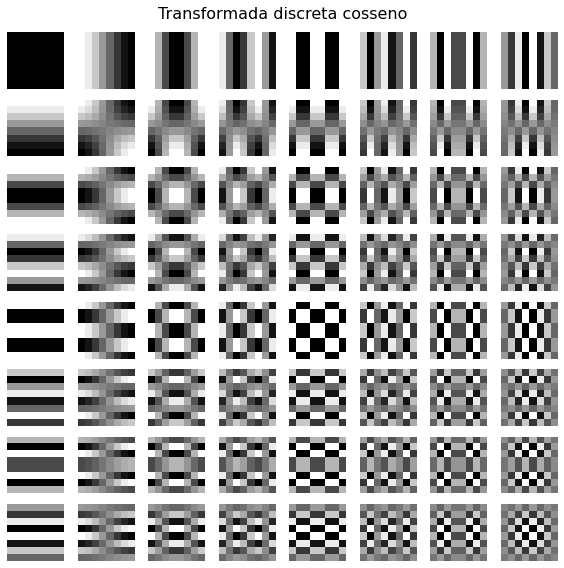

In [51]:
fig, axs = plt.subplots(8, 8, figsize=(8,8))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(IDC(j, i), cmap = "gray")
        
for ax in axs.flat:
    ax.label_outer()
    ax.axis('off')

fig.suptitle('Transformada discreta cosseno', fontsize=16)
fig.tight_layout();

In [52]:
def get_IDCs():
    IDCs = np.zeros((8,8,64))

    for y in range(0,8):
        for x in range(0,8):
            IDCs[:,:,zigzag[x+8*y]] = IDC(x,y)
    return IDCs

IDCs = get_IDCs()

Agora mostramos as forma na ordem (linha a linha), que são utilizadas na hora de compor o jpeg. Os mais para o final muitas vezes são truncados.

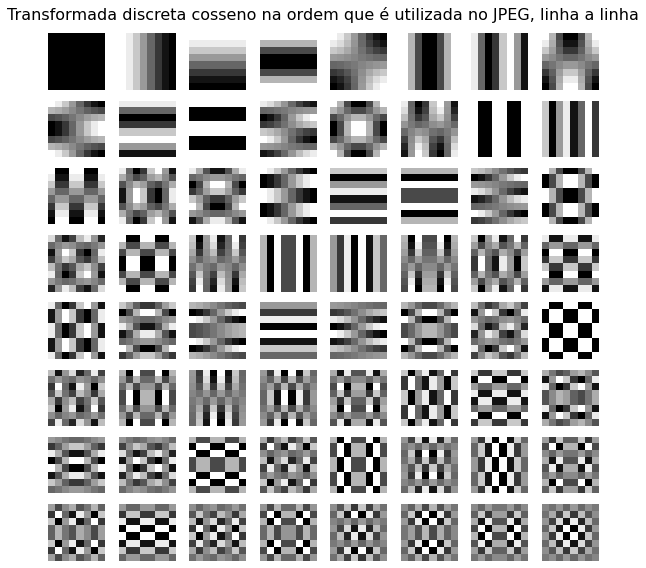

In [53]:
fig, axs = plt.subplots(8, 8, figsize=(8,8))

for i in range(8):
    for j in range(8):
        axs[j,i].imshow(IDCs[:,:,i+j*8], cmap = "gray")
        
for ax in axs.flat:
    ax.label_outer()
    ax.axis('off')
    
fig.suptitle('Transformada discreta cosseno na ordem que é utilizada no JPEG, linha a linha', fontsize=16)
fig.tight_layout();

Usamos as funções acima para gerar as transformadas utilizadas para transformar a imagem para o domínio da frequência.

In [54]:
def forma_imagem(decodificado, n_qt):
    return (IDCs*decodificado[np.newaxis,np.newaxis]*qt_tb[n_qt][np.newaxis,np.newaxis])

In [55]:
dados_imagem_hex = segmentos[-1]
dados_imagem_hex = dados_imagem_hex.replace("FF00", "FF")
dados_imagem_bin = bin(int(dados_imagem_hex, 16))[2:]

image = np.zeros((altura,largura,3)).astype(int)

dccoeff_Y_old = 0
dccoeff_Cb_old = 0
dccoeff_Cr_old = 0

MCUs = {}

# Decodifica cada um dos MCU 8x8 da imagem
for y in range(altura//8):
    for x in range(largura//8):
        dados_imagem_bin, binarios = get_RLC(dados_imagem_bin,  dict_componentes[1]) # Extraí os binários
        decodificado_Y, dccoeff_Y_old = decode_bin2int(binarios, dccoeff_Y_old) # Converte os binários para números
        # Usa os números, a tabela de quantização para formar e as formas da transformada cosseno para formar a imagem 
        base_Y = forma_imagem(decodificado_Y, 0)
        
        dados_imagem_bin, binarios = get_RLC(dados_imagem_bin,  dict_componentes[2])
        decodificado_Cr, dccoeff_Cr_old = decode_bin2int(binarios, dccoeff_Cr_old)
        base_Cr = forma_imagem(decodificado_Cr, 1)
        
        dados_imagem_bin, binarios = get_RLC(dados_imagem_bin,  dict_componentes[3])
        decodificado_Cb, dccoeff_Cb_old = decode_bin2int(binarios, dccoeff_Cb_old)
        base_Cb = forma_imagem(decodificado_Cb, 1)

        MCUs[str(x)+"_"+str(y)] = (base_Y, base_Cr, base_Cb, decodificado_Y.copy())
        
        image[(y*8):(y*8)+8,(x*8):(x*8)+8,:] = np.transpose(np.array((base_Y.sum(axis=2), 
            base_Cr.sum(axis=2), base_Cb.sum(axis=2))).reshape((3,8,8)), (1, 2, 0))

## Endentendo como funciona a composição

Pegamos a componente de crominância do terceiro MCU, que é um "T".

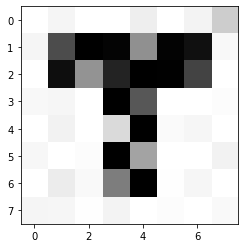

In [56]:
plt.imshow(MCUs["2_0"][0].sum(axis=2), cmap = "gray", vmin=-128, vmax=128)

Abaixo exibimos cada uma das formas da DCT utilizadas para compor a imagem do lado esquerdo e do direto essas formas já somadas até a componente solicitada. Também exibimos a matriz com os pesos que cada forma da DCT tem na imagem.

In [57]:
MCUs["2_0"][3].reshape((8,8))

array([[ 83.,   5., -46.,  16.,   5.,  91.,  -3.,   2.],
       [  2.,  33.,  45.,   1., -28.,   1.,  -8.,   1.],
       [ 19.,   4.,  -5.,   0.,  10.,   3.,   0., -10.],
       [  3.,   8.,  -1.,   8.,   1.,   0.,  -1.,  -7.],
       [  0.,   1.,   0.,  -1.,   1.,  -2.,   0.,  -4.],
       [  0.,  -3.,   2.,   0.,  -1.,   1.,  -5.,   0.],
       [  0.,  -3.,   0.,   1.,  -1.,  -2.,  -2.,   1.],
       [  0.,   1.,   4.,   0.,   0.,   2.,   1.,  -3.]])

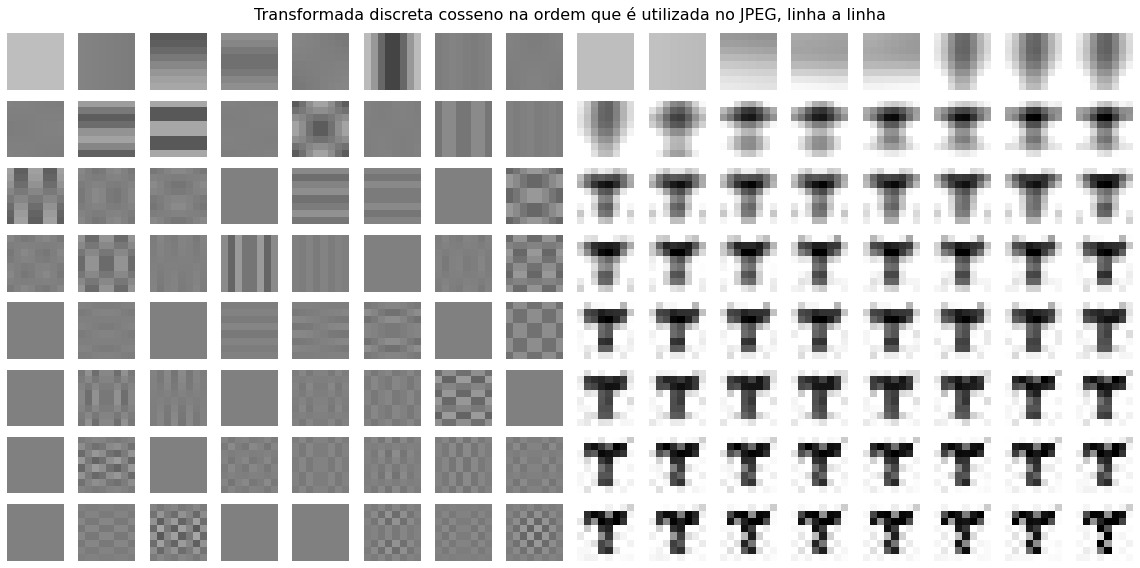

In [58]:
fig, axs = plt.subplots(8, 16, figsize=(16,8))

for i in range(8):
    for j in range(8):
        axs[j,i].imshow(MCUs["2_0"][0][:,:,i+j*8], cmap = "gray", vmin=-128, vmax=128)

for i in range(8):
    for j in range(8):
        axs[j,i+8].imshow(MCUs["2_0"][0][:,:,:i+j*8+1].sum(axis=2), cmap = "gray", vmin=-128, vmax=128)
        
for ax in axs.flat:
    ax.label_outer()
    ax.axis('off')
    
fig.suptitle('Transformada discreta cosseno na ordem que é utilizada no JPEG, linha a linha', fontsize=16)
fig.tight_layout();

## Transformando as cores de Luminância/Crominância para RGB

In [59]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.dot(xform.T)+128
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

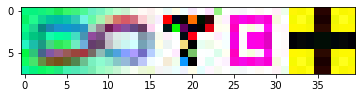

In [60]:
plt.imshow(ycbcr2rgb(image))

# Conclusões

Talvez o mais impressionante do JPEG seja que depois 30 anos é virtualmente o padrão de imagem utilizado na internet/celulares/Windows. Outros formatos como PNG/GIF tem objetivos distintos, o PNG não é uma compactação lossless, sem perda de qualidade, logo os arquivos são bem maiores, GIF é mais utilizado em vídeos curtos (cada vez menos). Diversos formatos foram criados, como JPEG 2000, um padrão fadado ao fracasso devido a patentes, WebP, HD Photo/JPEG XR, mas nenhum pegou. O JPEG é um perfeito exemplo do "bom o bastante".

No caso da codificação de vídeo diversos novos padrões vieram e realmente foram utilizados, pois o espaço ocupado na compactação é significativamente menor. O MPEG é fortemente baseado no JPEG, talvez o MPEG2 utilizado em DVDs também seja. Depois veio o DivX/MPEG4, H.264 (Blurays), por último o H.265/HEVC (Bluray Ultra HD). Em imagens também tivemos diversos padrões, muito viraram padrões JPEG, mas só agora tem um que acredito que possa vir a substituir o JPEG, JPEG XL, pois respeitaram o legado do JPEG, permitindo salvar novamente, mantendo a mesma qualidade e diminuindo o tamanho (provavelmente utilizando uma codificação mais eficiênte do que a de Huffman.

O JPEG é interessante, pois permite entender as técnicas que até hoje são utilizadas na compactação de imagens/vídeos (DCTs são utilizadas tanto no H.265, quanto no JPEG XL), permite aprender um pouco de codificação, código de Huffman é muito importante para computação ([olá Shannon](https://en.wikipedia.org/wiki/Information_theory)). Com um pouco mais de trabalho (talvez bastante) seria possível partir para uma decodificação de vídeo, a principal diferença seria adicionar [Motion Compensation](https://en.wikipedia.org/wiki/Motion_compensation), quem sabe no futuro.